In [2]:
%%capture
%pip install ray
%pip install tensorboardx
%pip install matplotlib

In [3]:
import ray
from ray import air, tune
from ray.air import session

# HPO with Ray Tune

The task in this notebook is to use Ray Tune to optimize the hyperparameters, namely "a" and "b", of the function "objective_function".

In [4]:
def objective_function(a, b):
  for i in range(10):
    a = a*b

## Random Search

Try to use Ray Tune with the random hyperparameter search. For that purpose you need to modify the function so that it is compatible with Ray Tune, e.g. change the input argument (needs to take a dictionary as input) and report the training progress to Ray. Furthermore you need to define a tuner and run it. If the return value is named "results" the training results can be displayed in the following cell.

Hint: Ray automatically uses random search if you do not specify any search algorithm

In [5]:
def objective_function(config):
  a = config["a"]
  b = config["b"]

  for i in range(10):
    a = a*b
    session.report({"metric": a})

param_space = {
    "a": tune.uniform(0,100),
    "b": tune.uniform(0,1)
}

tuner = tune.Tuner(
    objective_function,
    param_space = param_space,
    tune_config = tune.TuneConfig(
        num_samples = 5,
        metric="metric",
        mode="max",
        )
    )

results = tuner.fit()

2023-01-23 19:24:14,214	INFO worker.py:1538 -- Started a local Ray instance.


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,metric,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_function_24740_00000,2023-01-23_19-24-17,True,,93135d5ba21240c48610589d7505e1a5,"0_a=50.0530,b=0.5734",raphael-20ujs00k00,10,0.192347,192.168.188.20,189005,0.0606513,0.00239015,0.0606513,1674498257,0,,10,24740_00000,0.0030694
objective_function_24740_00001,2023-01-23_19-24-19,True,,974601cedc464830811ba64e280db6ce,"1_a=69.7725,b=0.6636",raphael-20ujs00k00,10,1.15627,192.168.188.20,189099,0.0449066,0.00215077,0.0449066,1674498259,0,,10,24740_00001,0.00272942
objective_function_24740_00002,2023-01-23_19-24-19,True,,a08d63cb5bdf4a8a80ec6dbd6c870a0b,"2_a=59.9807,b=0.8554",raphael-20ujs00k00,10,12.5825,192.168.188.20,189101,0.0553336,0.00353956,0.0553336,1674498259,0,,10,24740_00002,0.00337505
objective_function_24740_00003,2023-01-23_19-24-19,True,,e6abf9c9c70e4f619490ae88d865c447,"3_a=74.8985,b=0.6485",raphael-20ujs00k00,10,0.985038,192.168.188.20,189103,0.0381856,0.00422716,0.0381856,1674498259,0,,10,24740_00003,0.00298643
objective_function_24740_00004,2023-01-23_19-24-19,True,,0ef72be96a6946689863ed3ab7ccdf13,"4_a=67.0585,b=0.5238",raphael-20ujs00k00,10,0.104304,192.168.188.20,189105,0.049376,0.00351381,0.049376,1674498259,0,,10,24740_00004,0.00360084


2023-01-23 19:24:19,573	INFO tune.py:762 -- Total run time: 4.10 seconds (3.09 seconds for the tuning loop).


{'a': 59.980671264612205, 'b': 0.8554123961471181}


Text(0, 0.5, 'Mean accuracy')

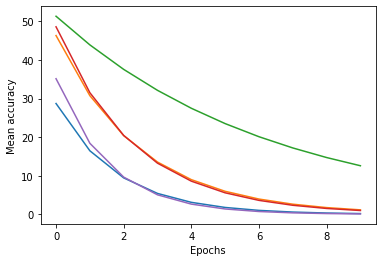

In [6]:
print(results.get_best_result().config)

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.plot(ax=ax, y="metric", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")

## Random Search with ASAH

This time add the ASAH scheduler to the random search.

In [9]:
def objective_function_asah(config):
  a = config["a"]
  b = config["b"]

  for i in range(10):
    a = a*b
    session.report({"metric": a})

scheduler = tune.schedulers.ASHAScheduler(
    max_t = 10,
    time_attr = "training_iteration",
    grace_period = 3
)

param_space = {
    "a": tune.uniform(0,100),
    "b": tune.uniform(0,1)
}

tuner = tune.Tuner(
    objective_function_asah,
    param_space = param_space,
    tune_config = tune.TuneConfig(
        num_samples = 20,
        metric="metric",
        mode="max",
        scheduler = scheduler,
        )
    )

results_asah = tuner.fit()

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,metric,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_function_asah_307d6_00000,2023-01-23_19-24-39,True,,12a6334d82604ff1a160e76a0a6795f0,raphael-20ujs00k00,10,4.93866e-10,192.168.188.20,191228,0.707624,0.0880651,0.707624,1674498279,0,,10,307d6_00000,0.00338268
objective_function_asah_307d6_00001,2023-01-23_19-24-43,True,,e362ca828f9040888882e67a178f3566,raphael-20ujs00k00,3,3.82779,192.168.188.20,191820,0.734672,0.0541844,0.734672,1674498283,0,,3,307d6_00001,0.00984764
objective_function_asah_307d6_00002,2023-01-23_19-24-43,True,,242284dcc9ef4333890f71a0720a0918,raphael-20ujs00k00,10,2.90621,192.168.188.20,191822,0.741915,0.0128407,0.741915,1674498283,0,,10,307d6_00002,0.0102806
objective_function_asah_307d6_00003,2023-01-23_19-24-43,True,,4138db5bf2194c60a199710029400d3d,raphael-20ujs00k00,3,0.00165526,192.168.188.20,191824,0.226774,0.0292532,0.226774,1674498283,0,,3,307d6_00003,0.00793839
objective_function_asah_307d6_00004,2023-01-23_19-24-43,True,,e93d3b8d7ef94aab9e705cb950ad068d,raphael-20ujs00k00,3,0.486381,192.168.188.20,191826,0.691056,0.077632,0.691056,1674498283,0,,3,307d6_00004,0.0144904
objective_function_asah_307d6_00005,2023-01-23_19-24-43,True,,1a582ab2a0014fd7977dd86d07f41973,raphael-20ujs00k00,3,0.217849,192.168.188.20,191828,0.268288,0.0191414,0.268288,1674498283,0,,3,307d6_00005,0.00486827
objective_function_asah_307d6_00006,2023-01-23_19-24-43,True,,927d3fbfbf404424bf796526f84e9aec,raphael-20ujs00k00,10,23.3558,192.168.188.20,191830,0.483901,0.00413871,0.483901,1674498283,0,,10,307d6_00006,0.0040338
objective_function_asah_307d6_00007,2023-01-23_19-24-43,True,,a876a90eca294caeb01d25e743bc8076,raphael-20ujs00k00,3,6.64758,192.168.188.20,191832,0.530141,0.00676036,0.530141,1674498283,0,,3,307d6_00007,0.00537038
objective_function_asah_307d6_00008,2023-01-23_19-24-43,True,,4229885ca49b452286892feab808ee7f,raphael-20ujs00k00,3,0.00487598,192.168.188.20,191834,0.431487,0.0608528,0.431487,1674498283,0,,3,307d6_00008,0.00721145
objective_function_asah_307d6_00009,2023-01-23_19-24-43,True,,3b1718aadf804ddeb0404bb419c8b51c,raphael-20ujs00k00,10,25.5906,192.168.188.20,191836,0.628624,0.00328827,0.628624,1674498283,0,,10,307d6_00009,0.00584412


2023-01-23 19:24:43,881	INFO tune.py:762 -- Total run time: 8.21 seconds (7.96 seconds for the tuning loop).


{'a': 39.25857972982341, 'b': 0.9581081071033282}


Text(0, 0.5, 'Mean accuracy')

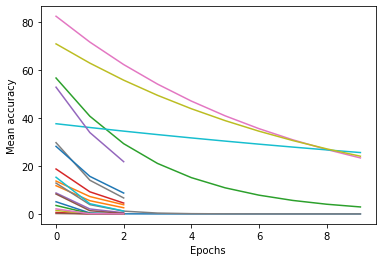

In [10]:
print(results_asah.get_best_result().config)

ax = None
dfs = {result.log_dir: result.metrics_dataframe for result in results_asah}
for d in dfs.values():
    ax = d.plot(ax=ax, y="metric", legend=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean accuracy")